In [1]:
import json
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from pycocotools.coco import COCO


In [3]:
def load_annot(annot_path: str):
    with open(annot_path) as annotation_file:
        return json.load(annotation_file)

ANNOT_PATH = r'..\hack2023urban\urbanhack-train\annotations\instances_default.json'
DATA_PATH = '..\\hack2023urban\\urbanhack-train\\images\\'


annotation = load_annot(ANNOT_PATH)
annotation

{'licenses': [{'name': '', 'id': 0, 'url': ''}],
 'info': {'contributor': '',
  'date_created': '',
  'description': '',
  'url': '',
  'version': '',
  'year': ''},
 'categories': [{'id': 1, 'name': 'window', 'supercategory': ''},
  {'id': 2, 'name': 'empty', 'supercategory': ''},
  {'id': 3, 'name': 'filled', 'supercategory': ''}],
 'images': [{'id': 1,
   'width': 854,
   'height': 572,
   'file_name': '0000019949building.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0},
  {'id': 2,
   'width': 881,
   'height': 720,
   'file_name': '0000019869building.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0},
  {'id': 3,
   'width': 847,
   'height': 544,
   'file_name': '0000019458building.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0},
  {'id': 4,
   'width': 303,
   'height': 600,
   'file_name': '0000019455building.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': ''

PyCocoTools и визуализация

In [4]:
coco=COCO(ANNOT_PATH)

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!


In [5]:
imgIds = coco.getImgIds()


annotsIds = coco.getAnnIds()
# print('Total annots: {}'.format(len(annotsIds)))
# rand_annot = coco.loadAnns(coco.getAnnIds(imgIds=img['id']))

len(imgIds)

252

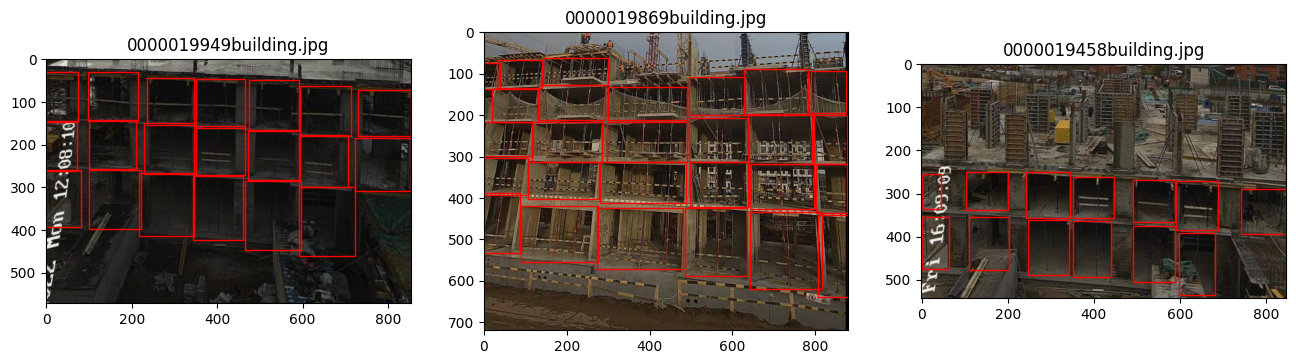

In [6]:
from matplotlib.patches import Rectangle

# def get_img_id_filename(imgId) -> str:
#     out = coco.loadImgs(imgId)[0]
#     return out

def _getAnnotsToPlot(imgId):
    annotsIds = coco.getAnnIds(imgIds=imgId)
    return coco.loadAnns(annotsIds)

def do_plot(ax, img):
    file_name = coco.loadImgs(img)[0]['file_name']
    ax.imshow(plt.imread(DATA_PATH + file_name))
    annots = _getAnnotsToPlot(img)
    # coco.showAnns(annots)
    # добавить bbox
    for i in annots:
        ax.add_patch(
            Rectangle((i['bbox'][0], i['bbox'][1]), i['bbox'][2], i['bbox'][3],
            edgecolor='red',
            facecolor='none',
            ))
        
    ax.set_title(file_name)

BATCH_SIZE = 3
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

for index, ax in enumerate(axes):
    do_plot(ax, index+1)

plt.show()

TFRecords

In [7]:
records_path=r'..\\hack2023urban\\TFRecords'
import os 
import tensorflow as tf

In [8]:
def get_annotations(imgId):
    annIds=coco.getAnnIds(imgIds=imgId)
    anns=coco.loadAnns(annIds)

    bboxes=[]
    catIds=[]
    iscrowd_list=[]
    area_list=[]
    annotation_ids=[]

    for ann in anns:
        catId=ann['category_id']
        bbox=ann['bbox']
        iscrowd=ann['iscrowd']
        area=ann['area']
        annotation_id=ann['id']

        catIds.append(catId)

        bboxes.append(bbox)
        iscrowd_list.append(iscrowd)
        area_list.append(area)
        annotation_ids.append(annotation_id)
    return len(anns),catIds,sum(bboxes, []),iscrowd_list,area_list,annotation_ids

In [22]:
import io
examples=[]
imgids=imgIds

    
for img in coco.loadImgs(imgids):
    with tf.io.gfile.GFile(DATA_PATH+img['file_name'],'rb') as f:
        encoded_jpg=f.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
  
    
    objects, catsIds, bboxes, iscrowd_list,area_list,annotation_ids = get_annotations(img['id'])
    print("cats", catsIds)
    print('annot', annotation_ids)
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_jpg])),
        'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['height']])),
        'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['width']])),
        'file_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['file_name'])])),
        'bboxes': tf.train.Feature(float_list=tf.train.FloatList(value=bboxes)),
        'category_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=catsIds)),
        'annotation_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=annotation_ids)),
        'objects': tf.train.Feature(int64_list=tf.train.Int64List(value=[objects])),

        # 'id': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['id']])),
        # 'license': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['license']])),
        

        # 'coco_url': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['coco_url'])])),
        # 'flickr_url': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['flickr_url'])])),
        # 'date_captured': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['date_captured']])),
        
        
        # 'segmentation_lengths': tf.train.Feature(int64_list=tf.train.Int64List(value=segmentation_lengths)),
        # 'segmentations': tf.train.Feature(float_list=tf.train.FloatList(value=segmentations)),
        
        
        # 'iscrowd': tf.train.Feature(int64_list=tf.train.Int64List(value=iscrowd)),
        # 'area': tf.train.Feature(float_list=tf.train.FloatList(value=area)),
        
    }))
    examples.append(example)

with tf.io.TFRecordWriter('.\\DATA.tfrecord') as writer:
    for j in examples:
        writer.write(j.SerializeToString())

examples.clear()
print("file created")

cats [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
annot [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
cats [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
annot [21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
cats [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
annot [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
cats [1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 1, 3, 1, 3, 1, 1, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 3, 1, 3, 3, 1, 1]
annot [61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9

Try to fit the model

In [18]:
def parse_tfrecord_fn(feature):  
    features = tf.io.parse_single_example(
        feature,
        features={
        'image': tf.io.FixedLenFeature([],tf.string),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'objects': tf.io.FixedLenFeature([], tf.int64),
        'category_ids': tf.io.VarLenFeature(tf.int64),
        'annotation_ids': tf.io.VarLenFeature(tf.int64),
        'bboxes': tf.io.VarLenFeature(tf.float32),
        'file_name': tf.io.FixedLenFeature([], tf.string),
        
        #'id': tf.io.FixedLenFeature([], tf.int64),
        #'license': tf.io.FixedLenFeature([], tf.int64),
        
        #'coco_url': tf.io.FixedLenFeature([], tf.string),
        #'flickr_url': tf.io.FixedLenFeature([], tf.string),
        #'date_captured': tf.io.FixedLenFeature([], tf.int64),
        
        #'iscrowd': tf.io.VarLenFeature(tf.int64),
        #'area': tf.io.VarLenFeature(tf.float32),
    })  
    

    features["image"] = tf.io.decode_jpeg(features["image"], channels=3)

    features["bboxes"] = tf.sparse.to_dense(features["bboxes"])
    features['bboxes'] = tf.reshape(features['bboxes'], [features['objects'], 4])
    features['bboxes'] = tf.cast(features['bboxes'], tf.float32)

    features["category_ids"] = tf.sparse.to_dense(features["category_ids"])
    # features['category_ids'] = tf.reshape(features['category_ids'], [features['objects'],1])
    features["annotation_ids"] = tf.sparse.to_dense(features["annotation_ids"])
    
    bounding_boxes = {
        "classes": tf.cast(features["category_ids"], dtype=tf.int64),
        "boxes": features['bboxes'],
    }
    return features


In [16]:
def load_tfrecords(tfrecord_path):
    ds = tf.data.TFRecordDataset(tfrecord_path)
    ds = ds.map(
        lambda x: parse_tfrecord_fn(x),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return ds

ds = load_tfrecords("C:\\Users\\caretaker\\Documents\\way-to-ml\\hack2023urban\\DATA.tfrecord")
ds.as_numpy_iterator().next()

{'images': array([[[ 31,  23,  10],
         [ 35,  27,  14],
         [ 38,  32,  20],
         ...,
         [ 52,  52,  50],
         [ 47,  47,  45],
         [ 45,  45,  43]],
 
        [[ 32,  24,  11],
         [ 36,  28,  15],
         [ 39,  33,  21],
         ...,
         [ 59,  59,  57],
         [ 55,  55,  53],
         [ 53,  53,  51]],
 
        [[ 33,  25,  12],
         [ 37,  29,  16],
         [ 40,  34,  22],
         ...,
         [ 56,  56,  54],
         [ 54,  54,  52],
         [ 52,  52,  50]],
 
        ...,
 
        [[ 42,  41,  37],
         [ 63,  62,  58],
         [ 87,  86,  82],
         ...,
         [ 21,  22,  17],
         [ 21,  22,  17],
         [ 19,  20,  15]],
 
        [[131, 130, 126],
         [167, 166, 162],
         [183, 182, 178],
         ...,
         [ 21,  21,  19],
         [ 21,  21,  19],
         [ 19,  19,  17]],
 
        [[185, 184, 180],
         [228, 227, 223],
         [230, 229, 225],
         ...,
         [ 21,  21

In [13]:
from keras_cv import bounding_box

ImportError: cannot import name 'core' from partially initialized module 'tensorflow_datasets' (most likely due to a circular import) (c:\Users\caretaker\Documents\way-to-ml\lib\site-packages\tensorflow_datasets\__init__.py)

In [14]:
def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

In [15]:
train_ds = ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)

NameError: in user code:

    File "C:\Users\caretaker\AppData\Local\Temp\ipykernel_5768\2345912862.py", line 3, in dict_to_tuple  *
        inputs["bounding_boxes"], max_boxes=32

    NameError: name 'bounding_box' is not defined


NameError: name 'df' is not defined